In [1]:
#import extra libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import math
import torch
from sklearn.model_selection import train_test_split
import collections
import inspect
from d2l import torch as d2l
import collections
import inspect
from IPython import display
%matplotlib inline

In [2]:
#pytorch utility imports
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.utils import make_grid

#neural net imports
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [3]:
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)

True
True
NVIDIA GeForce GTX 1650 Ti


In [4]:
def add_to_class(Class):
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

In [5]:
class HyperParameters:
    def save_hyperparameters(self, ignore=[]):
        frame = inspect.currentframe().f_back
        _, _, _, local_vars = inspect.getargvalues(frame)
        self.hparams = {k:v for k, v in local_vars.items()
                        if k not in set(ignore+['self']) and not k.startswith('_')}
        for k, v in self.hparams.items():
            setattr(self, k, v)

In [6]:
class ProgressBoard(HyperParameters):
    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(3.5, 2.5), display=True):
        self.save_hyperparameters()
        
    def draw(self, x, y, label, every_n=1):
        Point = collections.namedtuple('Point', ['x', 'y'])
        if not hasattr(self, 'raw_points'):
            self.raw_points = collections.OrderedDict()
            self.data = collections.OrderedDict()
        if label not in self.raw_points:
            self.raw_points[label] = []
            self.data[label] = []
        points = self.raw_points[label]
        line = self.data[label]
        points.append(Point(x, y))
        if len(points) != every_n:
            return
        mean = lambda x: sum(x) / len(x)
        line.append(Point(mean([p.x for p in points]),
                          mean([p.y for p in points])))
        points.clear()
        if not self.display:
            return
        d2l.use_svg_display()
        if self.fig is None:
            self.fig = d2l.plt.figure(figsize=self.figsize)
        plt_lines, labels = [], []
        for (k, v), ls, color in zip(self.data.items(), self.ls, self.colors):
            plt_lines.append(d2l.plt.plot([p.x for p in v], [p.y for p in v],
                                          linestyle=ls, color=color)[0])
            labels.append(k)
        axes = self.axes if self.axes else d2l.plt.gca()
        if self.xlim: axes.set_xlim(self.xlim)
        if self.ylim: axes.set_ylim(self.ylim)
        if not self.xlabel: self.xlabel = self.x
        axes.set_xlabel(self.xlabel)
        axes.set_ylabel(self.ylabel)
        axes.set_xscale(self.xscale)
        axes.set_yscale(self.yscale)
        axes.legend(plt_lines, labels)
        display.display(self.fig)
        display.clear_output(wait=True)
    




In [7]:
class Module1(nn.Module, HyperParameters):
    def __init__(self, plot_train_per_epoch = 2, plot_valid_per_epoch = 1):
        super().__init__()
        self.save_hyperparameters()
        self.board = ProgressBoard()
    
    def loss(self, Y_hat, y, averaged = True):
        Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
        Y = Y.reshape((-1,))
        return F.cross_entropy(
            Y_hat, Y, reduction='mean' if averaged else 'none')

    def accuracy(self, Y_hat, y, averaged = True):
        Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
        preds = Y_hat.argmax(axis=1).type(y.dtype)
        compare = (preds == y.reshape(-1)).type(torch.float32)
        return compare.mean() if averaged == True else compare

    def forward(self, X): 
        assert hasattr(self, 'net')
        return self.net(X)
    
    def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, value.to(d2l.cpu()).detach().numpy(), 
                    ('train_' if train else 'val_') + key,
                    every_n = int(n))
    
    def training_step(self, batch):
        #print(*batch[:-1])
        Y_hat = self(*batch[:-1])
        l = self.loss(Y_hat, batch[-1])
        self.plot('loss', l, train=True)
        return l
    
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train = False)
        self.plot('acc', self.accuracy(Y_hat, batch[-1]))
    
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(),lr = self.lr) #params, lr=<required parameter>, momentum=0,
                                         #dampening=0, weight_decay=0, nesterov=False, *, 
                                         #maximize=False, foreach=None, differentiable=False
            
    def layer_summary(self, X_shape):
        X = torch.randn(*X_shape)
        for layer in self.net:
            X = layer(X)
            print(layer.__class__.__name__, 'output shape:\t', X.shape)
    
    

In [8]:
class Classifier(Module1):
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)
        
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)

    def accuracy(self, Y_hat, Y, averaged=True):
        """Compute the number of correct predictions."""
        Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
        preds = Y_hat.argmax(axis=1).type(Y.dtype)
        compare = (preds == Y.reshape(-1)).type(torch.float32)
        return compare.mean() if averaged else compare
    
    def layer_summary(self, X_shape):
        X = torch.rand(*X_shape)
        for layer in self.net:
            X = layer(X)
            print(layer.__class__.__name__, 'output shape:\t', X.shape)
            
    def loss(self, Y_hat, Y, averaged=True):
        Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
        Y = Y.reshape((-1,))
        return F.cross_entropy(
            Y_hat, Y, reduction='mean' if averaged else 'none')

In [9]:
class DataModule(nn.Module, HyperParameters):
    def __init__(self, root='../data', num_workers = 4):
        super().__init__()
        self.save_hyperparameters()
    
    def get_dataloader(self, train):
        #label = ''
        data = self.train if train else self.val 
        #if label not in data: return 
        #using log label
        #get_tensor = lambda x: torch.tensor(x.values, dtype = torch.float32)
        #tensors = (get_tensor(data.drop(columns = label)), torch.log(get_tensor((data[label])).reshape(-1, 1)))
        #return get_tensorloader(tensors, train)
        return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=self.num_workers)
    
    def train_dataloader(self):
        return self.get_dataloader(train = True)
    
    def val_dataloader(self, train = False):
        return self.get_dataloader(train = True)
    
    def show_gray(self, start, end):
        figure = plt.figure()
        X, y = next(iter(data.train_dataloader()))
        for idx in range(start, end):
            plt.subplot(330 + (idx+1))
            plt.axis('off')
            plt.imshow(X[idx].numpy().squeeze(), cmap = plt.get_cmap('gray'))
            plt.title(y[idx]) 
    
        

In [10]:
class Trainer(HyperParameters):
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        self.gpus = [d2l.gpu(i) for i in range(min(num_gpus, d2l.num_gpus()))]

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)

    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        if self.gpus:
            model.to(self.gpus[0])
        self.model = model
    
    def prepare_batch(self, batch):
        if self.gpus:
            batch = [a.to(self.gpus[0]) for a in batch]
        return batch
        
    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()
    
    def fit_epoch(self):
        self.model.train()
        for batch in self.train_dataloader:
            #print(batch)
            loss = self.model.training_step(self.prepare_batch(batch))
            self.optim.zero_grad()
            with torch.no_grad():
                loss.backward()
                if self.gradient_clip_val > 0:  # To be discussed later
                    self.clip_gradients(self.gradient_clip_val, self.model)
                self.optim.step()
            self.train_batch_idx += 1
        if self.val_dataloader is None:
            return
        self.model.eval()
        for batch in self.val_dataloader:
            with torch.no_grad():
                self.model.validation_step(self.prepare_batch(batch))
            self.val_batch_idx += 1

In [11]:
#handwritting digit implement
#loading dataset
class MNIST(DataModule):
    def __init__(self, batch_size=64, resize=(28, 28)):
        super().__init__()
        self.save_hyperparameters()
        trans = transforms.Compose([transforms.Resize(resize), 
                                   transforms.ToTensor(), 
                                   transforms.Normalize((0.5,), (0.5,))])
        self.train = datasets.MNIST('PATH_TO_STORE_TRAINSET',
                                    download = True, train = True, transform = trans)
        self.val = datasets.MNIST('PATH_TO_STORE_TRAINSET',
                                    download = True, train = True, transform = trans)

In [12]:
data = MNIST(batch_size = 128, resize=(96, 96))
len(data.train), len(data.val)

(60000, 60000)

In [13]:
data.train[11]

(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 5)

torch.Size([128, 1, 96, 96]) torch.float32 torch.Size([128]) torch.int64


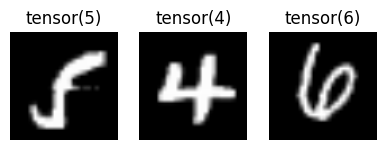

In [14]:
X, y = next(iter(data.train_dataloader()))
print(X.shape, X.dtype, y.shape, y.dtype)
data.show_gray(10, 13)

In [15]:
#ResNet
def init_cnn(module): #initialize weight
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

In [16]:
class Residual(nn.Module):  #@save
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv = False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d() 
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [17]:
class ResNet(Classifier):
    def __init__(self, arch, lr=0.1, num_classes = 10):
        super(ResNet, self).__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(self.b1())
        for i, b in enumerate(arch):
            self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
        self.net.add_module('last', nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(), 
            nn.LazyLinear(num_classes)))
        self.net.apply(init_cnn)
    
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2,padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    
    def block(self, num_residual, num_channels, first_block=False):
        blk = []
        for i in range(num_residual):
            if i == 0 and not first_block:
                blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                blk.append(Residual(num_channels))
        return nn.Sequential(*blk)

    
    

In [18]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)), lr, num_classes)
        
ResNet18().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


D:\miniconda3\envs\d2l\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


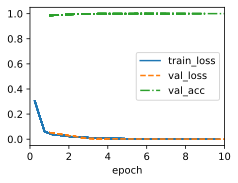

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ResNet18(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
#model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

In [20]:
X, y = next(iter(data.val_dataloader()))
X, y = X.to(device), y.to(device)
preds = model(X).argmax(axis=1)
preds.shape

torch.Size([128])

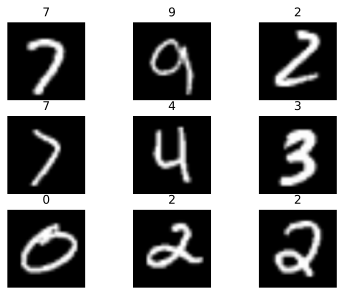

In [26]:
num_sample = 9
for idx, k in enumerate(X):
    if num_sample != 0: 
        plt.subplot(330 + (idx+1))
        plt.axis('off')
        plt.imshow(X[idx].cpu().numpy().squeeze(), cmap = plt.get_cmap('gray'))
        plt.title(preds[idx].cpu().numpy().squeeze()) 
        num_sample -= 1
    else: pass